In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
ed = tfp.edward2
import sys
sys.path.append("../")
from future_features import tape
import numpy as np
from plot_utils import plot_source_distributions

/home/folzd/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from testsuite import MAP_model, neg_log_lik

/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/folzd/anaconda3/lib/python3.6/im

In [3]:
from tfpmodels import independentFactorAnalysis, centeredIndependentFactorAnalysis
from tfpmodels import centeredIndependentFactorAnalysisTest
from tfpmodels import centeredIndependentFactorAnalysisTest2
from mapper import Mapper

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import FastICA, PCA

In [5]:
sess = tf.InteractiveSession()

In [6]:
n_components_in_mixture = 10
n_sources = 2
n_features = 2
n_observations = 5000

In [7]:
ifa = Mapper(centeredIndependentFactorAnalysis, 'ifa2', ['data'], n_observations=n_observations, n_components_in_mixture=n_components_in_mixture, n_features=n_features, n_sources=n_sources, mixture_component_var_concentration=.1*3, mixture_component_var_rate=1.*3,data_var_concentration=.1*3,data_var_rate=10.*3)

In [8]:
ifa.unconstrained_variables

{'mixture_component_var': <tf.Variable 'ifa2/mixture_component_var:0' shape=(2, 10) dtype=float32_ref>,
 'mixture_weights': <tf.Variable 'ifa2/mixture_weights:0' shape=(2, 9) dtype=float32_ref>,
 'sources': <tf.Variable 'ifa2/sources:0' shape=(5000, 2) dtype=float32_ref>,
 'factor_loadings': <tf.Variable 'ifa2/factor_loadings:0' shape=(2, 2) dtype=float32_ref>,
 'data_var': <tf.Variable 'ifa2/data_var:0' shape=(1, 2) dtype=float32_ref>}

In [9]:
generated = sess.run(ifa.tape)

In [10]:
fica = FastICA(n_components=n_sources).fit(generated['data']).mixing_.T
loss, opt = ifa.map_optimizer(data=generated['data'])
sess.run(tf.global_variables_initializer())

# Initialize in true parameters, as a sanity check
true_parameters = dict(generated)
true_parameters.pop('data')
sess.run(ifa.assigner(**true_parameters))

# FastICA, large SNR initialization
#sess.run(tf.assign(ifa.unconstrained_variables['factor_loadings'], fica,name='initialize_directions'))
#sess.run(tf.assign(ifa.unconstrained_variables['mixture_component_var'], 10*generated['data'].var()*np.random.rand(n_sources,n_components_in_mixture),name='initialize_signal_variance'))
#sess.run(tf.assign(ifa.unconstrained_variables['data_var'], 1e-3*np.ones(ifa.unconstrained_variables['data_var'].shape),name='initialize_noise_variance'))

initialized_parameters = sess.run(ifa.variables)
#initialized_parameters.pop('sources')
train_nll_init = neg_log_lik(initialized_parameters,centeredIndependentFactorAnalysisTest,generated['data'])
#sess.run(tf.assign(ifa.unconstrained_variables['sources'], 2*np.ones(ifa.variable_shapes['sources'])))
#opt.minimize()

In [11]:
true_parameters['data_var']

array([[0.00178799, 0.01529043]], dtype=float32)

In [12]:
true_parameters['sources'].var(0)

array([0.03681457, 0.10491129], dtype=float32)

In [13]:
map_estimates = dict(ifa.variables)
map_estimates.pop('sources')

<tf.Tensor 'ifa2/sources/read:0' shape=(5000, 2) dtype=float32>

In [14]:
testmodel,source = centeredIndependentFactorAnalysisTest2(n_observations=n_observations, **map_estimates)
source_sample = sess.run(source.distribution.sample((5000)))

In [15]:
source_sample.var(0)

array([0.03846867, 0.11406801], dtype=float32)

[[0.00178797 0.01529042]]
[0.03514463 0.10852376]


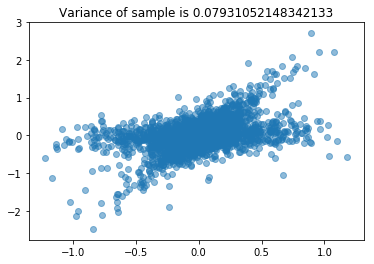

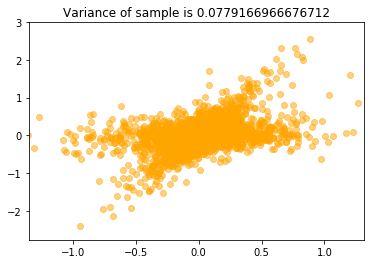

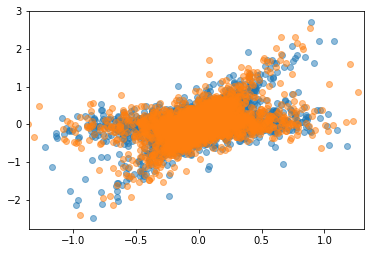

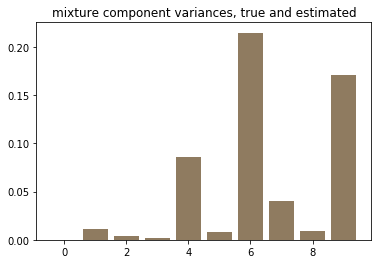

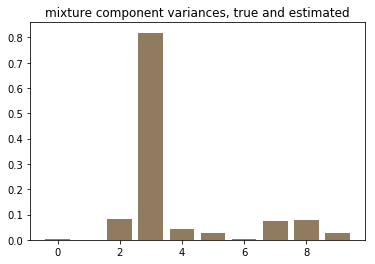

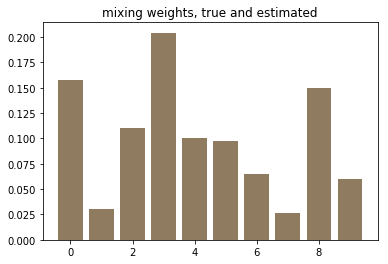

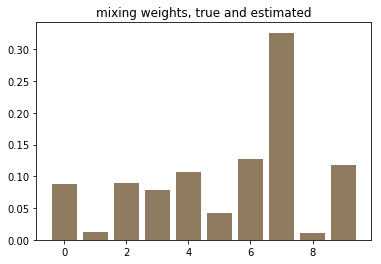

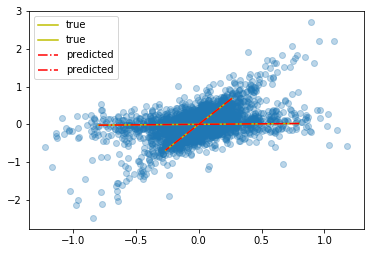

In [16]:
map_estimates = dict(ifa.variables)
map_estimates.pop('sources')

generated_vars = generated.copy()
map_estimate_vars = sess.run(map_estimates)

testmodel,source = centeredIndependentFactorAnalysisTest2(n_observations=n_observations, **map_estimates)
print(sess.run(map_estimates['data_var']))
print(sess.run(source.distribution.sample((5000))).var(0))
ppc = sess.run(testmodel.distribution.sample())

#plot_source_distributions(generated['mixture_component_var'],sess)
#plot_source_distributions(map_estimates['mixture_component_var'],sess)

fig, ax = plt.subplots()
plt.title('Variance of sample is {}'.format(generated['data'].var()))
plt.scatter(*generated['data'].T,alpha=.5)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
plt.show()

fig, ax = plt.subplots()
plt.title('Variance of sample is {}'.format(ppc.var()))
plt.scatter(*ppc.T, alpha=.5,c='orange')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

fig, ax = plt.subplots()
plt.scatter(*generated['data'].T,alpha=.5)
plt.scatter(*ppc.T, alpha=.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.show()

for source in range(n_sources):
    plt.title('mixture component variances, true and estimated')
    plt.bar(np.arange(n_components_in_mixture),generated_vars['mixture_component_var'][source,:])
    plt.bar(np.arange(n_components_in_mixture),map_estimate_vars['mixture_component_var'][source,:],alpha=.5)
    plt.show()

for source in range(n_sources):
    plt.title('mixing weights, true and estimated')
    plt.bar(np.arange(n_components_in_mixture),generated_vars['mixture_weights'][source,:])
    plt.bar(np.arange(n_components_in_mixture),map_estimate_vars['mixture_weights'][source,:],alpha=.5)
    plt.show()
    
fgen = generated['factor_loadings']
fpred = map_estimate_vars['factor_loadings']
fig, ax = plt.subplots()
ax.scatter(*generated['data'].T,alpha=0.3)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

for fg in fgen:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='y',label='true')

for fg in fpred:
    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='r', linestyle='-.', label='predicted')

#for fg in fica_n:
#    plt.plot(fg[0]*np.array([1,-1]),fg[1]*np.array([1,-1]),color='k',linestyle='--',label='initial')

plt.legend()
ax.set_xlim(xlim)
ax.set_ylim(ylim);

In [17]:
train_nll = neg_log_lik(map_estimates,centeredIndependentFactorAnalysisTest,generated['data'])

In [18]:
sess.run(train_nll_init)

-0.020741822

In [19]:
# run train_nll 100 times to estimate variance of the log-likelihood estimate
#train_nlls = []
#for i in range(100):
    #train_nlls.append(sess.run(train_nll_init))
#train_nlls = np.array(train_nlls)
#print(train_nlls)
#print(train_nlls.mean())
#print(train_nlls.std())

In [20]:
generated_vars.pop('data')
train_nll_true_model = neg_log_lik(generated_vars,centeredIndependentFactorAnalysisTest,generated['data'])

In [21]:
sess.run(train_nll_true_model)

-0.024626056

In [22]:
print(generated['mixture_component_var'])
print(map_estimate_vars['mixture_component_var'])

[[2.07976453e-04 1.09020835e-02 3.96258058e-03 1.43345352e-03
  8.63782763e-02 7.95211177e-03 2.14844361e-01 4.06272076e-02
  9.50579625e-03 1.70896292e-01]
 [2.97601731e-03 9.83882230e-04 8.38267580e-02 8.18657100e-01
  4.19593006e-02 2.59755198e-02 1.43238495e-03 7.60397986e-02
  7.65659437e-02 2.83406582e-02]]
[[2.0799857e-04 1.0902126e-02 3.9625238e-03 1.4334176e-03 8.6378284e-02
  7.9521015e-03 2.1484439e-01 4.0627159e-02 9.5058437e-03 1.7089632e-01]
 [2.9760378e-03 9.8382705e-04 8.3826758e-02 8.1865704e-01 4.1959308e-02
  2.5975505e-02 1.4323462e-03 7.6039761e-02 7.6565959e-02 2.8340708e-02]]


In [23]:
print(generated['mixture_component_var'].mean(1))
print(map_estimate_vars['mixture_component_var'].mean(1))

[0.05467101 0.11567575]
[0.05467102 0.11567573]


In [24]:
print(generated['data_var'])
print(map_estimate_vars['data_var'])

[[0.00178799 0.01529043]]
[[0.00178797 0.01529042]]


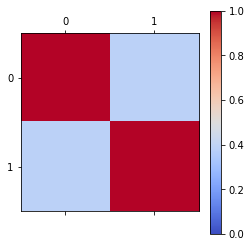

In [25]:
plt.matshow(np.abs(cosine_similarity(generated['factor_loadings'],map_estimate_vars['factor_loadings'])),cmap='coolwarm',vmin=0,vmax=1)
plt.colorbar()

In [26]:
generated_vars

OrderedDict([('mixture_component_var',
              array([[2.07976453e-04, 1.09020835e-02, 3.96258058e-03, 1.43345352e-03,
                      8.63782763e-02, 7.95211177e-03, 2.14844361e-01, 4.06272076e-02,
                      9.50579625e-03, 1.70896292e-01],
                     [2.97601731e-03, 9.83882230e-04, 8.38267580e-02, 8.18657100e-01,
                      4.19593006e-02, 2.59755198e-02, 1.43238495e-03, 7.60397986e-02,
                      7.65659437e-02, 2.83406582e-02]], dtype=float32)),
             ('mixture_weights',
              array([[0.1573092 , 0.02991144, 0.11009038, 0.20434529, 0.10027321,
                      0.09708974, 0.06479167, 0.02650271, 0.14976443, 0.05992191],
                     [0.08809961, 0.01231678, 0.08965233, 0.07780712, 0.10731856,
                      0.04141467, 0.12793027, 0.3260724 , 0.01126928, 0.11811896]],
                    dtype=float32)),
             ('sources', array([[-0.02299047,  0.13319391],
                     [-0.042

In [27]:
map_estimate_vars

{'mixture_component_var': array([[2.0799857e-04, 1.0902126e-02, 3.9625238e-03, 1.4334176e-03,
         8.6378284e-02, 7.9521015e-03, 2.1484439e-01, 4.0627159e-02,
         9.5058437e-03, 1.7089632e-01],
        [2.9760378e-03, 9.8382705e-04, 8.3826758e-02, 8.1865704e-01,
         4.1959308e-02, 2.5975505e-02, 1.4323462e-03, 7.6039761e-02,
         7.6565959e-02, 2.8340708e-02]], dtype=float32),
 'mixture_weights': array([[0.15730922, 0.02991144, 0.11009039, 0.20434529, 0.10027322,
         0.09708973, 0.06479167, 0.0265027 , 0.14976443, 0.05992192],
        [0.08809961, 0.01231678, 0.08965233, 0.07780712, 0.10731857,
         0.04141467, 0.12793027, 0.3260724 , 0.01126928, 0.11811896]],
       dtype=float32),
 'factor_loadings': array([[0.79864085, 0.02167365],
        [0.26338145, 0.6850821 ]], dtype=float32),
 'data_var': array([[0.00178797, 0.01529042]], dtype=float32)}

In [28]:
try:
    generated_vars.pop('sources')
except:
    pass
for param_pair in zip(generated_vars.values(),map_estimate_vars.values()):
    print(param_pair)
    print(np.allclose(*param_pair,rtol=0.001))

(array([[2.07976453e-04, 1.09020835e-02, 3.96258058e-03, 1.43345352e-03,
        8.63782763e-02, 7.95211177e-03, 2.14844361e-01, 4.06272076e-02,
        9.50579625e-03, 1.70896292e-01],
       [2.97601731e-03, 9.83882230e-04, 8.38267580e-02, 8.18657100e-01,
        4.19593006e-02, 2.59755198e-02, 1.43238495e-03, 7.60397986e-02,
        7.65659437e-02, 2.83406582e-02]], dtype=float32), array([[2.0799857e-04, 1.0902126e-02, 3.9625238e-03, 1.4334176e-03,
        8.6378284e-02, 7.9521015e-03, 2.1484439e-01, 4.0627159e-02,
        9.5058437e-03, 1.7089632e-01],
       [2.9760378e-03, 9.8382705e-04, 8.3826758e-02, 8.1865704e-01,
        4.1959308e-02, 2.5975505e-02, 1.4323462e-03, 7.6039761e-02,
        7.6565959e-02, 2.8340708e-02]], dtype=float32))
True
(array([[0.1573092 , 0.02991144, 0.11009038, 0.20434529, 0.10027321,
        0.09708974, 0.06479167, 0.02650271, 0.14976443, 0.05992191],
       [0.08809961, 0.01231678, 0.08965233, 0.07780712, 0.10731856,
        0.04141467, 0.12793027, 0.

In [29]:
param_pair

(array([[0.00178799, 0.01529043]], dtype=float32),
 array([[0.00178797, 0.01529042]], dtype=float32))

In [30]:
np.allclose(*param_pair)

True